In [0]:
import tensorflow as tf 
import numpy as np
import os
import pandas as pd
import time
from os import listdir
import functools
import pickle
import math
from IPython import display as ipythondisplay
from tqdm import tqdm

from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10855627688620019691
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 17424495803030355944
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 18097567115471418291
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11150726272
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16690077339616391235
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [0]:
import subprocess
import regex as re

import matplotlib.pyplot as plt
from IPython import display as ipythondisplay


from IPython.display import Audio
from string import Formatter





def display_model(model):
  tf.keras.utils.plot_model(model,
             to_file='tmp.png',
             show_shapes=True)
  return ipythondisplay.Image('tmp.png')


def plot_sample(x,y,vae):
    plt.figure(figsize=(2,1))
    plt.subplot(1, 2, 1)

    idx = np.where(y==1)[0][0]
    plt.imshow(x[idx])
    plt.grid(False)

    plt.subplot(1, 2, 2)
    _, _, _, recon = vae(x)
    recon = np.clip(recon, 0, 1)
    plt.imshow(recon[idx])
    plt.grid(False)

    plt.show()



class LossHistory:
  def __init__(self, smoothing_factor=0.0):
    self.alpha = smoothing_factor
    self.loss = []
  def append(self, value):
    self.loss.append( self.alpha*self.loss[-1] + (1-self.alpha)*value if len(self.loss)>0 else value )
  def get(self):
    return self.loss

class PeriodicPlotter:
  def __init__(self, sec, xlabel='', ylabel='', scale=None):

    self.xlabel = xlabel
    self.ylabel = ylabel
    self.sec = sec
    self.scale = scale

    self.tic = time.time()

  def plot(self, data):
    if time.time() - self.tic > self.sec:
      plt.cla()

      if self.scale is None:
        plt.plot(data)
      elif self.scale == 'semilogx':
        plt.semilogx(data)
      elif self.scale == 'semilogy':
        plt.semilogy(data)
      elif self.scale == 'loglog':
        plt.loglog(data)
      else:
        raise ValueError("unrecognized parameter scale {}".format(self.scale))

      plt.xlabel(self.xlabel); plt.ylabel(self.ylabel)
      ipythondisplay.clear_output(wait=True)
      ipythondisplay.display(plt.gcf())

      self.tic = time.time()
        
cwd = os.getcwd()

In [0]:
def LSTM(rnn_units): 
  return tf.keras.layers.LSTM(
    rnn_units, 
    return_sequences=True, 
    recurrent_initializer='glorot_uniform',
    recurrent_activation='sigmoid',
    stateful=True,
  )

def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
   
    model = tf.keras.Sequential([
    
      tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),

      
      LSTM(rnn_units), 
      
      tf.keras.layers.Dense(vocab_size)
      
    ])

    return model

In [0]:
def compute_loss(labels, logits):
  loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
  return loss

In [0]:
modelF = build_model(200, embedding_dim=512, rnn_units=2048, batch_size=60)

In [0]:
infile = open('/content/drive/My Drive/MusicData/balladTest.pkl','rb')
testData = pickle.load(infile)
infile.close()

In [0]:
num_training_iterations = 50
instrument = 'bass'
batchSize = 60
#checkpoint_dir = '/content/drive/Shared drives/Digital Musicology 2020/HouseMusicData/housedrums' 
checkpoint_dir = '/content/drive/My Drive/MusicData/balladBass' 
checkpoint_prefix = os.path.join(checkpoint_dir, "balladBass")
modelF.load_weights(checkpoint_prefix)

In [0]:
def cut_output(y_hat, instrument ):
    if(instrument=='drums'):
      y_hat = y_hat[:,0:30]
    if(instrument=='piano'):
      y_hat = y_hat[:,30:60]
    if(instrument=='guitar'):
      y_hat = y_hat[:,60:90]
    if(instrument=='bass'):
      y_hat = y_hat[:,90:120]
    return y_hat

In [0]:
def encode_notes_full(notesArr):
    size = math.ceil(notesArr[-1:][1])
    sizeF = size*4
    mod = sizeF%batchSize
    pad = 0
    if(mod != 0):
         pad = batchSize - mod
    encodeNotes =  pd.DataFrame([[0.0]*30]*(sizeF+pad))
    length = len(notesArr)
    count = 0
    partInt=0
    for i in range(length):
        start = notesArr[0][i]
        count = 0
        end = notesArr[1][i]
        dur = float(end) - float(start)
        startInt = int(float(start))
        part = float(start) - startInt
        index = (startInt)*4
        if(part<=0.25):
            partInt = 0
        elif(0.25<part<=0.5):
            partInt = 1
        elif(0.5<part<=0.75):
            partInt = 2
        elif(0.75<part<=1.0):
            partInt = 3
        #print(partInt)
        for j in range(29):
            if(encodeNotes[j][index + partInt]==0.0 and encodeNotes[j+1][index + partInt]==0.0 and encodeNotes[j+2][index + partInt]==0.0):
                #print('here')
                encodeNotes[j][index + partInt] = dur
                encodeNotes[j+1][index + partInt] = notesArr[2][i]
                encodeNotes[j+2][index + partInt] = notesArr[3][i]
                break
    return encodeNotes

In [0]:
def get_encoded_song( songNum, instrument):
    drums = encode_notes_full(testData[0][songNum])
    piano = encode_notes_full(testData[1][songNum])
    guitar = encode_notes_full(testData[2][songNum])
    bass = encode_notes_full(testData[3][songNum])
    fullSong = pd.concat([drums, piano, guitar, bass], axis=1, sort=False)
    fullSong.fillna(0.0, inplace=True)
    if(instrument=='drums'):
        drums.fillna(0.0, inplace=True)
        return fullSong, drums
    if(instrument=='piano'):
        piano.fillna(0.0, inplace=True)
        return fullSong, piano
    if(instrument=='guitar'):
        guitar.fillna(0.0, inplace=True)
        return fullSong, guitar
    if(instrument=='bass'):
        bass.fillna(0.0, inplace=True)
        return fullSong, bass

In [0]:
def get_batchF(encodedNotes, encodedIns1, iteration, batchSize):

    idx = int(iteration * batchSize)
    input_batch = encodedNotes[idx:(idx+batchSize)].values
    output_batch = encodedIns1[(idx+batchSize):(idx+(batchSize*2))].values
    output_batch[output_batch > 200] = 200
    output_batch[output_batch < 0] = 0
    input_batch[input_batch > 200] = 200
    input_batch[input_batch < 0] = 0
    return input_batch, output_batch

In [0]:
def loss_data_type(y, y_hat):
  #notesY =  pd.DataFrame([[0.0]*10]*(60))
  #notes_y_hat = [0.0] * 10
  #trackN = 0

  #durY =  pd.DataFrame([[0.0]*10]*(60))
  #dur_y_hat = [0.0] * 10
  #trackD = 0

  velY =  pd.DataFrame([[0.0]*10]*(60))
  vel_y_hat = [0.0] * 10
  trackV = 0
  
  for i in range(30):
      #if(i%3==0):
        #durY[:][trackD] = y[:,i]
        #dur_y_hat[trackD] = y_hat[:,i]
        #trackD += 1

      #if(i%2==0 and i%3!=0):
        #notesY[:][trackN] = y[:,i]
        #notes_y_hat[trackN] = y_hat[:,i]
        #trackN += 1

      if(i%2!=0 and i%3!=0):
        velY[:][trackV] = y[:,i]
        vel_y_hat[trackV] = y_hat[:,i]
        trackV += 1

  #dur_y_hat = np.reshape(dur_y_hat,(60, 10, 200))
  #dur_y_hat = tf.convert_to_tensor(dur_y_hat, dtype=tf.dtypes.float32)
  #lossD = compute_loss(durY, dur_y_hat) 

  #notes_y_hat = np.reshape(notes_y_hat,(60, 10, 200))
  #notes_y_hat = tf.convert_to_tensor(notes_y_hat, dtype=tf.dtypes.float32)
  #lossN = compute_loss(notesY, notes_y_hat) 

  vel_y_hat = np.reshape(vel_y_hat,(60, 10, 200))
  vel_y_hat = tf.convert_to_tensor(vel_y_hat, dtype=tf.dtypes.float32)
  lossV = compute_loss(velY, vel_y_hat) 
 
  return lossV

In [0]:
'''song, ins = get_encoded_song(1, instrument)
x_batch, y_batch = get_batchF(song, ins, 0, batchSize)
y_hat = modelF(x_batch) 
y_hat = cut_output(y_hat, instrument)
print(y_hat.shape)
print(y_batch.shape)
loss_data_type(y_batch, y_hat)
print(compute_loss(y_batch, y_hat))
print('boop')'''

"song, ins = get_encoded_song(1, instrument)\nx_batch, y_batch = get_batchF(song, ins, 0, batchSize)\ny_hat = modelF(x_batch) \ny_hat = cut_output(y_hat, instrument)\nprint(y_hat.shape)\nprint(y_batch.shape)\nloss_data_type(y_batch, y_hat)\nprint(compute_loss(y_batch, y_hat))\nprint('boop')"

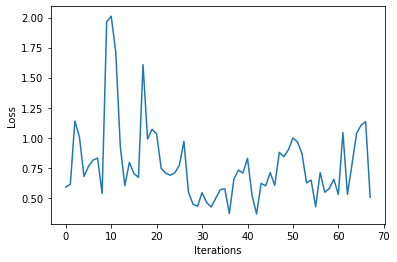

 76%|███████▌  | 38/50 [32:50<11:34, 57.88s/it]

0


In [0]:
def test_step(x, y): 
  
  y_hat = modelF(x) 
  y_hat = cut_output(y_hat, instrument)
  #loss = compute_loss(y, y_hat) 
  lossN = loss_data_type(y, y_hat)
  return lossN

#history= []
#historyD = []
historyN = []
#historyV = []
count = 0

plotter = PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')

if hasattr(tqdm, '_instances'): tqdm._instances.clear() 
for iter in tqdm(range(num_training_iterations)):
      
      song, ins = get_encoded_song(iter, instrument)
      
      for j in range(int(min((len(song)/batchSize)-1,int((len(ins)/batchSize)-1)))):
          print(j)
          x_batch, y_batch = get_batchF(song, ins, j, batchSize)
          loss = test_step(x_batch, y_batch)
          count += 1

          
          historyN.append(loss.numpy().mean())
          plotter.plot(historyN)


In [0]:
print(count)

2


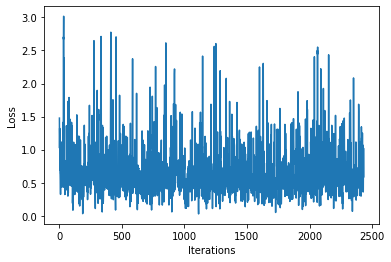

100%|██████████| 1487/1487 [11:34<00:00,  2.14it/s]


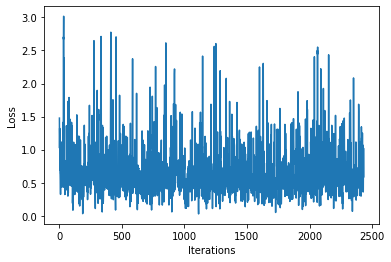

In [0]:
def test_step(x, y): 
  
  y_hat = modelF(x) 
  y_hat = cut_output(y_hat, instrument)
  loss = compute_loss(y, y_hat) 
  return loss

history = []
plotter = PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() 
for iter in tqdm(range(num_training_iterations)):
      
      song, ins = get_encoded_song(iter, instrument)
      
      for j in range(int(min((len(song)/batchSize)-1,int((len(ins)/batchSize)-1)))):
          print(j)
          x_batch, y_batch = get_batchF(song, ins, j, batchSize)
          loss = test_step(x_batch, y_batch)
          
          history.append(loss.numpy().mean())
          plotter.plot(history)


In [0]:
print(historyN)

[0.98702615, 1.4689819, 3.1641452, 2.1402009, 1.7908558, 1.399253, 1.3917004, 1.4937205, 0.91881806, 2.835941, 2.970587, 2.8265238, 1.6170363, 1.2988353, 1.689009, 2.01569, 1.5635886, 3.9773772, 3.500741, 2.1137743, 3.2574294, 1.5908624, 2.2695642, 2.3121555, 2.382733, 1.5949785, 1.6441877, 0.75786376, 0.76677036, 0.621948, 0.67216265, 0.6740605, 0.61415446, 2.0461876, 1.7006519, 1.6632482, 0.33415815, 1.527444, 1.5894394, 1.562717, 2.0527153, 1.2577463, 1.6397145, 1.2459038, 1.2421826, 2.5416176, 1.9053695, 2.5397365, 2.5581925, 2.5348723, 1.8200922, 2.0825562, 2.0379572, 2.8849747, 2.9544454, 2.1395257, 1.6045592, 1.3765078, 1.6071991, 1.7303605, 1.2216997, 1.4992707, 1.1078928, 1.3624625, 2.1350803, 1.5350261, 1.5662405, 1.979696, 1.9683228, 2.0621667, 2.0855381, 1.0738723, 1.1811374, 1.3160459, 0.3402655, 3.303884, 1.0001495, 2.6550283, 1.5333315, 1.7823389, 1.9748881, 1.8916382, 1.0124013, 0.24908756, 0.6120252, 0.0965775, 1.5008783, 1.6644605, 1.5966276, 1.0169619, 1.1254665]


In [0]:
pickle.dump(historyN, open("/content/drive/My Drive/MusicData/historyBalladBassN.pkl", "wb"))